The purpose of this lab is to introduce some tricks and tools to handle text.

We will do the following:
    * Work on preprocessing steps
    * See a typical task: topic detection
    * Run an exercise together: recomposing books with topic modelling
    * List of resources
    * More exercises for the brave

### Basic imports

In [2]:
# to support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# magics and warnings
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

# machinery
import os, codecs, string, random
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
import numpy as np
seed = 42 # reproducibility!
random.seed(seed)
random_seed(seed)
np.random.seed(seed)
import nltk, gensim, sklearn, spacy # the armory!
import matplotlib.pyplot as plt
import pyLDAvis.gensim

# where our books are
corpus_root = 'books/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Some data first
We have 4 books in the folder, in plain text.

In [3]:
# See Gutenberg Project for more: http://www.gutenberg.org/wiki/Main_Page
books = list()
for book_file in os.listdir(corpus_root): # use os functions to be os independent
    if ".txt" in book_file:
        print(book_file)
        with codecs.open(os.path.join(corpus_root,book_file),encoding="utf8") as f: # use codecs for a variety of encodings
            books.append(f.read())

Moby_Dick.txt
Frankenstein.txt
DRACULA.txt
PRIDE_AND_PREJUDICE.txt


In [4]:
books[0][:100]

'MOBY DICK;\n\nor, THE WHALE.\n\nBy Herman Melville\n\nETYMOLOGY. (Supplied by a Late Consumptive Usher to '

In [5]:
books = [" ".join(b.split()) for b in books] # getting rid of new lines and all extra white space

In [6]:
books[0][:100]

'MOBY DICK; or, THE WHALE. By Herman Melville ETYMOLOGY. (Supplied by a Late Consumptive Usher to a G'

In [7]:
# let's get all chars and their frequency
fdist1 = nltk.FreqDist(books[0])

In [8]:
fdist1.most_common(10)

[(' ', 212033),
 ('e', 116525),
 ('t', 85971),
 ('a', 75754),
 ('o', 68783),
 ('n', 64843),
 ('s', 62410),
 ('i', 62302),
 ('h', 61804),
 ('r', 51655)]

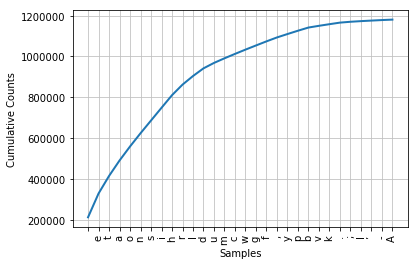

In [9]:
fdist1.plot(30,cumulative=True)

In [10]:
# tokens now
books_token = [nltk.word_tokenize(b) for b in books]

In [11]:
books_token[0][:10]

['MOBY', 'DICK', ';', 'or', ',', 'THE', 'WHALE', '.', 'By', 'Herman']

In [12]:
# let's get all words and their frequency
fdist2 = nltk.FreqDist(books_token[0])
fdist2.most_common(10)

[(',', 19207),
 ('the', 13706),
 ('.', 6916),
 ('of', 6551),
 ('and', 5992),
 ('to', 4512),
 ('a', 4501),
 (';', 4174),
 ('in', 3908),
 ('that', 2931)]

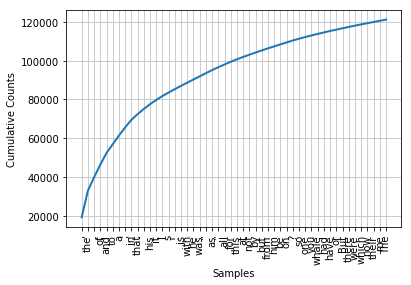

In [13]:
fdist2.plot(50,cumulative=True)

In [14]:
# Collocations (n-grams)
finder = nltk.collocations.BigramCollocationFinder.from_words(books_token[0])
bigram_measures = nltk.collocations.BigramAssocMeasures()
# explore measures for different outcomes!
finder.nbest(bigram_measures.pmi, 10)

[('*In', 'Sperm-whalemen'),
 ('2,800', 'firkins'),
 ('A.S.', 'Walwian'),
 ('AM', 'ESCAPED'),
 ('Agassiz', 'imagines'),
 ('Albert', 'Durer'),
 ('Anacharsis', 'Clootz'),
 ('Andrew', 'Jackson'),
 ('Animated', 'Nature.'),
 ('Anno', '1652')]

### Preprocessing

In [15]:
# Let's get sentences
books_sents = [nltk.sent_tokenize(b) for b in books]

In [16]:
# A basic (and crude) function to get rid of stopwords, punctuation, lower case, numbers
from nltk.corpus import stopwords
punctuation = string.punctuation+'“’—.”’“--,”' # pimp the list of punctuation to remove
def rem_stop(txt,stop_words=stopwords.words("english"),lower=True,punct=True):
    """
    Removes stopwords, punct and other things from a text, inc. numbers
    :param list txt: text tokens (list of str)
    :param list stop_words: stopwords to remove (list of str)
    :param bol lower: if to lowercase
    :param bol punct: if to rid punctuation
    """
    if lower and punct:
        return [t.lower() for t in txt if t.lower() not in stop_words and t.lower() not in punctuation and not t.isdigit()]
    elif lower:
        return [t.lower() for t in txt if t.lower() not in stop_words and not t.isdigit()]
    elif punct:
        return [t for t in txt if t.lower() not in stop_words and t.lower() not in punctuation and not t.isdigit()]
    return [t for t in txt if t.lower() not in stop_words and not t.isdigit()]

In [17]:
books_stop = [rem_stop(b,lower=False,punct=False) for b in books_token]

In [18]:
books_stop[0][:10]

['MOBY',
 'DICK',
 ';',
 ',',
 'WHALE',
 '.',
 'Herman',
 'Melville',
 'ETYMOLOGY',
 '.']

#### Stemming and lemmatizing

In [19]:
# our target
ranges = (102,118)
books_token[0][ranges[0]:ranges[1]]

['and',
 'to',
 'teach',
 'them',
 'by',
 'what',
 'name',
 'a',
 'whale-fish',
 'is',
 'to',
 'be',
 'called',
 'in',
 'our',
 'tongue']

In [20]:
# support function to work with WordNet POS tags
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):
    """
    Cf. https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
    :param treebank_tag: a tag from nltk.pos_tag treebank
    """
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [21]:
# stem and lemmatize
porter = nltk.PorterStemmer()
wnl = nltk.WordNetLemmatizer()
books_stem = [[porter.stem(t) for t in b] for b in books_token]
books_pos = [nltk.pos_tag(b) for b in books_token]
books_lem = [[wnl.lemmatize(t,pos=get_wordnet_pos(p[1])) for t,p in zip(b,bp)] for b,bp in zip(books_token,books_pos)]

In [22]:
# compare
for t,s,l in zip(books_token[0][ranges[0]:ranges[1]],books_stem[0][ranges[0]:ranges[1]],books_lem[0][ranges[0]:ranges[1]]):
    print(t, " - ", s," - ",l)

and  -  and  -  and
to  -  to  -  to
teach  -  teach  -  teach
them  -  them  -  them
by  -  by  -  by
what  -  what  -  what
name  -  name  -  name
a  -  a  -  a
whale-fish  -  whale-fish  -  whale-fish
is  -  is  -  be
to  -  to  -  to
be  -  be  -  be
called  -  call  -  call
in  -  in  -  in
our  -  our  -  our
tongue  -  tongu  -  tongue


In [23]:
# Let's load our corpus via NLTK
from nltk.corpus import PlaintextCorpusReader
?PlaintextCorpusReader

In [24]:
our_books = PlaintextCorpusReader(corpus_root, '.*.txt')
print(our_books.fileids())

['DRACULA.txt', 'Frankenstein.txt', 'Moby_Dick.txt', 'PRIDE_AND_PREJUDICE.txt']


In [25]:
# Note that we also have some from nltk
nltk.corpus.gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

### Typical task: topic detection
Let's get some sentences from nltk, move to gensim to get a BOW representation, go back to numpy for LSA



In [26]:
# get sentences
dracula_sentences = our_books.sents('DRACULA.txt')

In [27]:
dracula_sentences[:3]

[['DRACULA'], ['Bram', 'Stoker'], ['CHAPTER', 'I']]

In [28]:
# clean a bit
dracula_sentences = [rem_stop(s) for s in dracula_sentences]

In [29]:
dracula_sentences[:3]

[['dracula'], ['bram', 'stoker'], ['chapter']]

In [30]:
# create a dictionary and BOW representation using gensim
from gensim import corpora
dictionary = corpora.Dictionary(dracula_sentences)
# filter dictionary
max_freq = 0.5
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)
corpus = [dictionary.doc2bow(s) for s in dracula_sentences]
corpus = [s for s in corpus if len(s)>0] # filter out empty sentences

In [31]:
corpus[:3] # we loose some sentences in the process!

[[(2220, 1)], [(1475, 1)], [(85, 1), (1434, 1), (2096, 1)]]

In [32]:
dictionary.token2id["dracula"]

2220

In [33]:
# Let's move to numpy for LSA
matrix = gensim.matutils.corpus2dense(corpus,num_terms=len(dictionary))

In [34]:
matrix.T.shape # sentence x vocab matrix (your matrix from class, this is not tf-idf weighted)

(9028, 2276)

In [35]:
# (Almost) equivalent to:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(min_df=min_wordcount,max_df=max_freq)
X = count_vect.fit_transform([" ".join(s) for s in dracula_sentences]).todense()
X = X[np.asarray(np.sum(X, axis=1)>0).ravel(),:] # filter out empty sentences

# Also tf-idf
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=True).fit(X)
X_tf = tf_transformer.transform(X)
X_tf.shape

(8960, 2253)

#### Homemade LSA

In [36]:
# Run a SVD directly
n_topics = 5
U,S,_ = np.linalg.svd(matrix.T)
sentence_vectors = U[:,:n_topics]
print(sum(S[:n_topics])/sum(S)) # explained variance of the model

0.0146167704089


In [37]:
sentence_vectors[6,:]

array([ 0.01077735, -0.00154847,  0.02358575,  0.00248787, -0.01675043], dtype=float32)

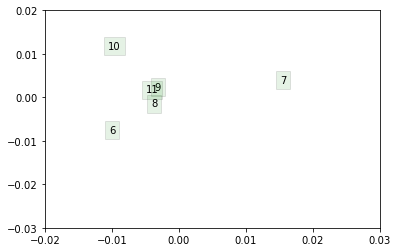

In [38]:
# PCA and plot
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X=U)

which_sentences = [6,7,8,9,10,11]

plt.figure()
for w in which_sentences:
    plt.text(X_pca[w,0], X_pca[w,1], w,
        bbox=dict(facecolor='green', alpha=0.1))

plt.xlim((-0.02,0.03))
plt.ylim((-0.03,0.02))
plt.show()

In [39]:
for n,sent in enumerate(dracula_sentences[6:12]):
    print(n+6," ".join(sent))

6 bistritz left munich p ., 1st may arriving vienna early next morning arrived train hour late
7 buda pesth seems wonderful place glimpse got train little could walk streets
8 feared go far station arrived late would start near correct time possible
9 impression leaving west entering east western splendid bridges danube noble width depth took us among traditions turkish rule
10 left pretty good time came nightfall klausenburgh
11 stopped night hotel royale


#### Proper LSA

In [40]:
# Let's use Gensim with tfidf
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
model = gensim.models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=n_topics)
model.show_topic(0)
#model[corpus_tfidf[0]]

[('said', -0.51312914330897363),
 (':--', -0.33601649049508392),
 ('."', -0.24536781825700915),
 ('van', -0.19970385099878801),
 ('helsing', -0.19970385099878801),
 ('?"', -0.19259481850683335),
 (',"', -0.17048329385911301),
 ('shall', -0.13814950680341045),
 ('know', -0.12126822354276665),
 ('must', -0.11431412995869636)]

In [41]:
# In sklearn use sklearn.decomposition import TruncatedSVD

### Exercise: recomposing books
A vandal has cut off all sentences from our books, and we would like to put them back again together!

#### Interlude on Topic Modelling

Main idea: assume documents are generated via topics (latent factors). 

For each document we select a few topics at varying proportions. 

Every topic is in turn a distrubition probability over words in the vocabulary.
    
Latent Dirichlet Allocation is one of the main techniques to estimate topics (Blei et al. 2003)

From Blei, 2012, Probabilistic Topic Models:

<img src="Blei.png">

#### Create the dataset
We will chunk sentences from every book to represent pages, more or less, which the vandal has torn off

In [42]:
def get_chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [43]:
# Get the data
book_id = {f:n for n,f in enumerate(our_books.fileids())} # dictionary of books
chunks = list()
chunk_class = list() # this list contains the original book of the chunk, for evaluation
limit = 60 # how many chunks total
size = 50 # how many sentences per chunk/page
for f in our_books.fileids():
    sentences = our_books.sents(f)
    print(f,":",len(sentences))
    # create chunks
    chunks_of_sents = [x for x in get_chunks(sentences,size)] # this is a list of lists of sentences, which are a list of tokens
    chs = list()
    # regroup so to have a list of chunks which are strings
    for c in chunks_of_sents:
        grouped_chunk = list()
        for s in c:
            grouped_chunk.extend(s)
        chs.append(" ".join(grouped_chunk))
    print("chunks:",len(chs))
    # filter to the limit, to have the same number of chunks per book
    chunks.extend(chs[:limit])
    chunk_class.extend([book_id[f] for _ in range(len(chs[:limit]))])

DRACULA.txt : 9303
chunks: 187
Frankenstein.txt : 3378
chunks: 68
Moby_Dick.txt : 9609
chunks: 193
PRIDE_AND_PREJUDICE.txt : 6055
chunks: 122


In [44]:
chunks[0][:100]

"DRACULA Bram Stoker CHAPTER I JONATHAN HARKER ' S JOURNAL ( _Kept in shorthand . _ ) _3 May . Bistri"

#### More robust pipeline with Spacy
<img src="spacy.png">

In [45]:
import spacy
STOPWORDS = spacy.en.language_data.STOP_WORDS
nlp = spacy.load('en')

processed_docs = list()
for doc in nlp.pipe(chunks, n_threads=5, batch_size=10):

    # Process document using Spacy NLP pipeline.
    ents = doc.ents  # Named entities

    # Keep only words (no numbers, no punctuation).
    # Lemmatize tokens, remove punctuation and remove stopwords.
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

    # Remove common words from a stopword list and keep only words of length 3 or more.
    doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]

    # Add named entities, but only if they are a compound of more than word.
    doc.extend([str(entity) for entity in ents if len(entity) > 1])

    processed_docs.append(doc)
docs = processed_docs
del processed_docs

In [46]:
# Add bigrams.
from gensim.models.phrases import Phrases
# Add bigrams to docs (only ones that appear 15 times or more).
bigram = Phrases(docs, min_count=15)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [47]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary = Dictionary(docs)
# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of chunks: %d' % len(corpus))

Number of unique tokens: 3068
Number of chunks: 240


In [55]:
# models
from gensim.models import LdaMulticore
params = {'passes': 10, 'random_state': seed}
base_models = dict()
model = LdaMulticore(corpus=corpus, num_topics=4, id2word=dictionary, workers=6,
                passes=params['passes'], random_state=params['random_state'])

In [56]:
model.show_topics(num_words=5)

[(0,
  '0.028*"whale" + 0.012*"ship" + 0.011*"captain" + 0.009*"queequeg" + 0.009*"old"'),
 (1,
  '0.016*"elizabeth" + 0.012*"darcy" + 0.011*"bingley" + 0.010*"miss" + 0.010*"lady"'),
 (2,
  '0.006*"dear" + 0.006*"father" + 0.006*"life" + 0.005*"love" + 0.004*"mind"'),
 (3,
  '0.007*"room" + 0.007*"door" + 0.006*"sea" + 0.006*"sleep" + 0.005*"count"')]

In [57]:
model.show_topic(1,20)

[('elizabeth', 0.015640554900789597),
 ('darcy', 0.011808009465055553),
 ('bingley', 0.010665116493220349),
 ('miss', 0.0096859488290914446),
 ('lady', 0.0096824688597904589),
 ('bennet', 0.0092363179659873292),
 ('mrs', 0.0092322555399384186),
 ('sister', 0.0077454350040913134),
 ('jane', 0.0074105604591136543),
 ('young', 0.0061657174369337646),
 ('collins', 0.0057655728816821223),
 ('wish', 0.004887491606181427),
 ('room', 0.0045532847536293997),
 ('mrs_bennet', 0.0044147926307568199),
 ('dear', 0.0044026367931454978),
 ('manner', 0.0041346765720949282),
 ('catherine', 0.0040787304327844203),
 ('wickham', 0.0039520520126349644),
 ('family', 0.0038539456632936675),
 ('charlotte', 0.0037764473613210517)]

In [58]:
sorted(model[corpus[0]],key=lambda x:x[1],reverse=True)

[(3, 0.99730842089085792)]

In [59]:
# plot topics
data =  pyLDAvis.gensim.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

In [60]:
# assignment
sent_to_cluster = list()
for n,doc in enumerate(corpus):
    if doc:
        cluster = max(model[doc],key=lambda x:x[1])
        sent_to_cluster.append(cluster[0])

In [61]:
# accuracy
from collections import Counter
for book, cluster in book_id.items():
    assignments = list()
    for real,given in zip(chunk_class,sent_to_cluster):
        if real == cluster:
            assignments.append(given)
    most_common,num_most_common = Counter(assignments).most_common(1)[0] # 4, 6 times
    print(book,":",most_common,"-",num_most_common)
    print("Accuracy:",num_most_common/limit)
    print("------")

Moby_Dick.txt : 0 - 42
Accuracy: 0.7
------
Frankenstein.txt : 2 - 58
Accuracy: 0.9666666666666667
------
PRIDE_AND_PREJUDICE.txt : 1 - 60
Accuracy: 1.0
------
DRACULA.txt : 3 - 42
Accuracy: 0.7
------


### List of resources
    * Jellyfish: string similarity library
    * TextBlob: simplified text processing
    * PyEnchant: language detection
    * WordNet: ontology of concepts (inc. in NLTK)
    * Stanford NLP (Java)
    * Tweet NLP: https://www.cs.cmu.edu/~ark/TweetNLP/

#### A word on WordNet
WordNet is an ontology of concepts, it follows the denotational approach to meaning (i.e. we give an explicit definition to the machine). What we did before follows the distributional hypothesis: words have meaning by the company they keep.

In [62]:
from nltk.corpus import wordnet as wn
print(wn.synsets('house'))
print("------")
print(wn.synset('house.n.01').definition())
print(wn.synset('house.n.02').definition())
print(wn.synset('home.n.02').definition())
print("------")
print(wn.synset('house.n.01').lowest_common_hypernyms(wn.synset('factory.n.01')))
print(wn.synset('house.n.01').lowest_common_hypernyms(wn.synset('home.n.02')))
print("------")
print(wn.synset('house.n.01').path_similarity(wn.synset('factory.n.01')))
print(wn.synset('house.n.01').path_similarity(wn.synset('home.n.02')))

[Synset('house.n.01'), Synset('firm.n.01'), Synset('house.n.03'), Synset('house.n.04'), Synset('house.n.05'), Synset('house.n.06'), Synset('house.n.07'), Synset('sign_of_the_zodiac.n.01'), Synset('house.n.09'), Synset('family.n.01'), Synset('theater.n.01'), Synset('house.n.12'), Synset('house.v.01'), Synset('house.v.02')]
------
a dwelling that serves as living quarters for one or more families
the members of a business organization that owns or operates one or more establishments
housing that someone is living in
------
[Synset('structure.n.01')]
[Synset('dwelling.n.01')]
------
0.16666666666666666
0.5


### Exercise for the brave

Consider word embeddings, a way to represent word features in dense vectors (cornerstone of deep learning methods for NLP).
There exist also document embeddings, which produce vectors to represent entire chunks of text such as sentences or paragraphs.
    * Consider the doc2vec method from the Gensim API: https://radimrehurek.com/gensim/models/doc2vec.html
    * Use it to produce embeddings for a sample of our dataset of chunks
    * Try to learn a supervised method (e.g. logistic regression or random forests) to predict the book a chunk is part of
    * How does it work?